In [1]:
import pandas as pd
import numpy as np
import os
import sys
from matplotlib.lines import Line2D
import time
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from utils.utils import *
from segmentation.segmentation import Segmentation
from sklearn import preprocessing
path = '../stats_files/'

In [2]:
dt = DataLoader()
dt.load('../sample_testing/sample2.log')
dt.extractinfo(export=True,single_file=False)

mongodb://localhost:27017/
Database connected


In [3]:
df = pd.DataFrame(dt.dbconnector.query('RCIN_sample_testing/sample2'))

In [4]:
df.head()

,_id,TimeUS,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,RCIN_0,RCIN_1,lineIndex
0,5cfd4a85048d2b431094bd23,216175259,1496,1488,1076,1480,1034,1801,982,982,1076,982,982,1494,1494,1494,604
1,5cfd4a85048d2b431094bd23,216276783,1496,1488,1076,1480,1034,1801,982,982,1076,982,982,1494,1494,1494,638
2,5cfd4a85048d2b431094bd23,216376533,1496,1488,1076,1480,1034,1801,982,982,1076,982,982,1494,1494,1494,661
3,5cfd4a85048d2b431094bd23,216476746,1496,1488,1076,1480,1034,1801,982,982,1076,982,982,1494,1494,1494,686
4,5cfd4a85048d2b431094bd23,216576692,1496,1488,1076,1479,1034,1801,982,982,1076,982,982,1494,1494,1494,709


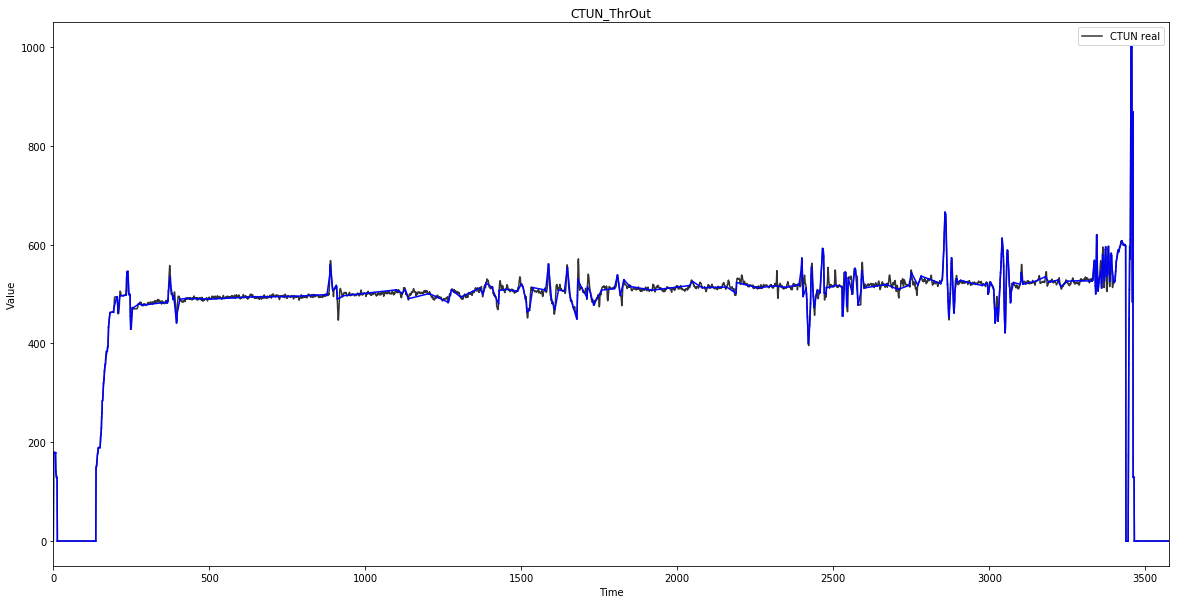

In [10]:
# runvsg = []
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlim()
# for i,gr in enumerate(np.arange(0,2,0.5)):
start_time = time.time()
sg = Segmentation(1)
comp ='CTUN'
va = 'ThrOut'
fitmethod= 'inter'
sgmethod = 'td'
sr = dt.dbconnector.query(comp+'_sample_testing/sample2',va)
sig_length = len(sr)
rng = dt.dbconnector.query(comp+'_sample_testing/sample2','lineIndex')
sg.segment(sr,seg_method=sgmethod,fit_method=fitmethod,save_seginstance=False,err_growth=0.5,batch=True,batch_size=10)
#print('Signal Run Time: {} , Growth Rate: {}'.format( time.time() - start_time,gr))
#     runvsg.append( time.time() - start_time)
#plt.subplot(2, 2, i+1)
sg.draw_plot(comp)#+'-'+comp+'_'+va)
rl, idx = sg.find_maxratio()
sg.draw_segments(highlight_idx = None)
plt.title(comp+'_'+va)
plt.show()
    #plt.savefig('../report/phase3/'+comp+'_'+va+'_'+sgmethod+'_'+fitmethod+'.png', dpi=500)

In [ ]:
sg.segments[idx]

In [ ]:
l = list(np.arange(0,2,0.5))
sns.lineplot(x=l,y=runvsg)
plt.title('Run Time vs Growth Rate')
plt.xlabel('Error Growth Rate')
plt.ylabel('RunTime sec')
plt.show()

In [ ]:
datalist =os.listdir('../data')
#added to the 100 variables
vardict = load_top100_dict()
vardict['RCOU'] = ['RCOU_Ch1','RCOU_Ch2','RCOU_Ccmdh3','RCOU_Ch4']

In [ ]:
dbc = DatabaseConnector('segdb','27017')

In [ ]:
loader = DataLoader()

In [ ]:
existing_collections = dbc.mydb.list_collection_names()
sg = Segmentation(0.5)
insert_data = True
check_insert =True
normalize = False
batch_size = 70
#------------------------------------------
time_list = []
fitmethod= 'inter'
sgmethod = 'td'
for i,log in enumerate(datalist):
    start_time = time.time()
    print('File:{} --  {} / {}'.format(log,i,len(datalist)-1))
    for k,v in vardict.items():
        res = loader.dbconnector.query(k+'_'+log[:-4]) #find signals in the log files 
        if res != -1: #data exists
                df = pd.DataFrame(res)
                df_size = len(df)
                print('Processing Component: {}.. Length: {}'.format(k,df_size))
                if df_size <= 5:
                    continue
                for val in list(set(df.columns).intersection(v)): #loop through the signals
                    cname = 'seg_'+k+'_'+val+'_'+log[:-4]
                    if cname in existing_collections:
                        continue
                    #print('        Signal: {}..'.format(val,df_size))
                    if not np.issubdtype(df[val].dtype, np.number):
                            cat_to_int(df,val)
                    if normalize:
                        srval = preprocessing.scale(df[val])
                    else:
                        srval = df[val]
                    list_segments = sg.segment(srval,seg_method=sgmethod,fit_method=fitmethod,
                                               save_seginstance=False,err_growth =0.1,batch_size=batch_size)
                    if isinstance(list_segments,int):
                        print('error in segments ', list_segments)
                        continue
                    #export list_segments into a collection
                    if insert_data:
                            if cname not in existing_collections:
                                time_list.append(time.time() - start_time)
                            dbc.set_collection(cname)
                            resp = dbc.insert_dict(pd.DataFrame(list_segments,columns=['x1','y1','x2','y2']).to_dict('list'))
                            if resp == -1:
                                print('Dict insert error in file : {}'.format(log[:-4]))
    print('File Run Time: ', time.time() - start_time)

In [ ]:
dbc.mydb.list_collection_names()

In [12]:
np.array([1,1,1,-1,0,-1])

array([ 1,  1,  1, -1,  0, -1])